In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, cross_val_score
from mlxtend import plotting
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import statsmodels.api as sm

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from xgboost import XGBClassifier


**1. Poznanie danych ze zbioru healtcare, odnosnie ataków serca**

In [2]:
#ładowanie datasetu o zawałach serca
df=pd.read_csv("healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
#usuniecie kolumny ID
del df["id"]

In [6]:
#sprawdzamy typy zmiennych
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [7]:
#sprawdzamy ile jest NA
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [4]:
#zamienimy na w kolumnie BMI, przy wykorzystaniu SimpleImputer z pakietu sklearn
imputer = SimpleImputer()

pom1 = df["bmi"].to_frame()
df["bmi"]=imputer.fit_transform(pom1)

In [5]:
#poznajmy trochę nasze dane:
df[df.columns[1:]].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Jak widzimy wartosci wskaznika BMI przy zastosowaniu Imputera zaczeły nam się kształtować ponad ramy dopuszczalnych wskazników.
Usuńmy jednak wartosci NA z tej zmiennej.

In [301]:
df=pd.read_csv("healthcare-dataset-stroke-data.csv")
del df["id"]

In [302]:
df = df[~df['bmi'].isnull()] 

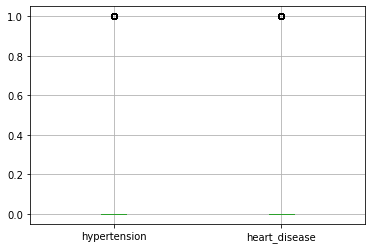

In [303]:
# poznajmy inne dane
zmienne_ciagle= df[df.columns[1:]].select_dtypes(include = ["float64","int64"])
zmienne_ciagle[zmienne_ciagle.columns[[1,2]]].boxplot()
pass

Widzimy, że zmienne hypertension i heart_disease to tak na prawdę zmienne kategoryczne

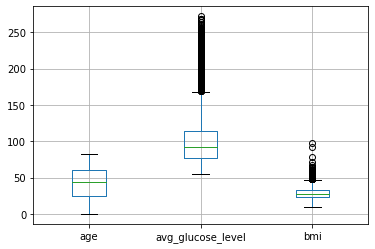

In [304]:
zmienne_ciagle[zmienne_ciagle.columns[[0,3,4]]].boxplot()
pass

  W przypadku pozostałych zmiennych ciągłych, mamy duzo wartości odstających dla avg_glucose_level i BMI. 
  Jednak nie wykluczałbym ich, ponieważ często przy chorobach pacjenci charakteryzują sie wysokimi wynikami.

plot of gender


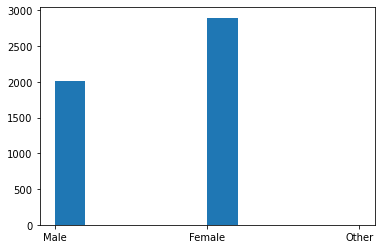

plot of ever_married


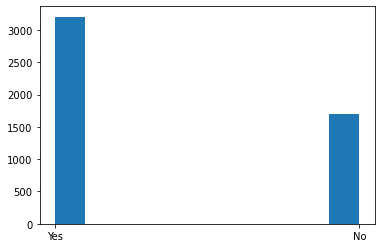

plot of work_type


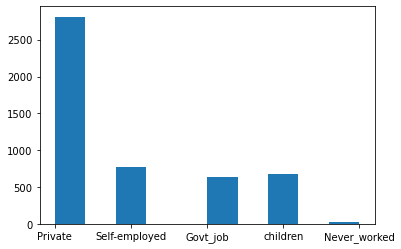

plot of Residence_type


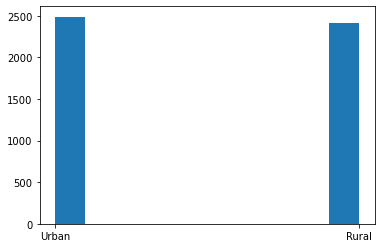

plot of smoking_status


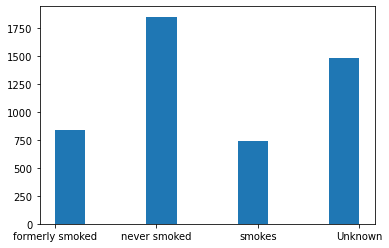

plot of hypertension


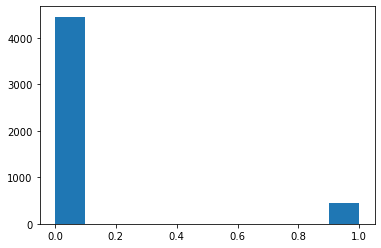

plot of heart_disease


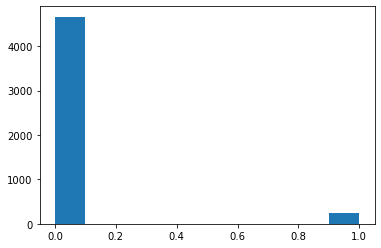

In [22]:
zmienne_kategoryczne = df.select_dtypes(include = "object").join(zmienne_ciagle[zmienne_ciagle.columns[[1,2]]])
for i in zmienne_kategoryczne.columns:
    plt.hist(df[i])
    print("plot of", i)
    plt.show()

In [24]:
for i in zmienne_kategoryczne.columns:
    print(f"Struktura zmiennej {i} \n{df[i].value_counts()/df.shape[0]} \n")

Struktura zmiennej gender 
Female    0.590141
Male      0.409656
Other     0.000204
Name: gender, dtype: float64 

Struktura zmiennej ever_married 
Yes    0.652679
No     0.347321
Name: ever_married, dtype: float64 

Struktura zmiennej work_type 
Private          0.572622
Self-employed    0.157873
children         0.136688
Govt_job         0.128336
Never_worked     0.004482
Name: work_type, dtype: float64 

Struktura zmiennej Residence_type 
Urban    0.507232
Rural    0.492768
Name: Residence_type, dtype: float64 

Struktura zmiennej smoking_status 
never smoked       0.377266
Unknown            0.302098
formerly smoked    0.170503
smokes             0.150132
Name: smoking_status, dtype: float64 

Struktura zmiennej hypertension 
0    0.908128
1    0.091872
Name: hypertension, dtype: float64 

Struktura zmiennej heart_disease 
0    0.950499
1    0.049501
Name: heart_disease, dtype: float64 



Widzimy, że mamy niemal o połowe wiecej kobiet w zbiorze i niewielki odsetek osób nieokreślonych.
Analizując zmienną ever_married możemy dostrzec, że było prawie dwa razy wiecej osób, ktore by kiedykolwiek po slubie.  
Najwięcej obserwacji dotyczy osob z sektora prywatnego i 3x mniej, niemal po równo, osób samozatrudnionych, wychowujących dzieci czy pracujących w państwowych instytucjach. Nigdy nie pracujacy stanowią 4 promile.  
W przypadku osób z nadciśnieniem (hypertension) mamy 90% oznaczonych jako 0 - brak i niecałe 10% cierpiących na te dolegliwosć.
Warto zwrócić uwagę na zmienna objaśnianą, czyli heart_disease mamy tylko w 5% przypadków oznaczonych jako 1, czyli gdzie wystąpił atak serca, należy to uwzględnić przy wyznaczenia setu testowego.

**2. Wstępna obróbka danych do modelu**

In [25]:
# zmiana kolumn kategorycznych na typ category
for i in df.select_dtypes(include = 'object').join(df[["hypertension","heart_disease"]]):
       df[i]=df[i].astype('category')

In [26]:
# wyznaczenie dummy variables
df_dummy = pd.get_dummies(df,drop_first= True)

In [27]:
# zdefiniujmy zbiór X i Y bez podzialu na testowy do ewentualnej cross validacji
X = df_dummy.iloc[:,0:3].join(df_dummy.iloc[:,4:])
Y = df_dummy["stroke"]

In [28]:
# podzielmy też na zbiór treningowy i testowy
X_train, X_test, Y_train,Y_test = train_test_split(X,Y, test_size = 0.2)

**3. Na początku zaczniemy od prostego modelu drzewa decyzyjnego**

In [33]:
# prosty model drzewa decyzyjnego, nr1
model_dd1 = DecisionTreeClassifier(random_state=1).fit(X_train, Y_train)

Y_pred_dd1 =  model_dd1.predict(X_test)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_dd1.score(X_train, Y_train),4), "\n",
      "acc test: ", round(model_dd1.score(X_test, Y_test),4))

acc train:  1.0 
 acc test:  0.9084


W zasadzie acc moglaby nam powiedziec, ze model jest bardzo dobry, ale pamietajmy, ze mamy niezbalansowany zbior 5:95

In [34]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_dd1 = confusion_matrix(Y_test, Y_pred_dd1)
raport_dd1 = classification_report(Y_test, Y_pred_dd1)
print(raport_dd1)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       935
           1       0.15      0.19      0.17        47

    accuracy                           0.91       982
   macro avg       0.55      0.57      0.56       982
weighted avg       0.92      0.91      0.91       982



Na podstawie macierzy błędu, widzimy, że ta metoda zapewnia nam niską precyzję dla klasy 1.   
Model nie nadaje się do produkcji!

**4. Spróbujmy dostroić model drzewa decyzyjnego i stworzyc kolejny model dd2**

In [35]:
# stwórzmy najpierw zestaw parametrów do testów
params_dd2 = {"max_depth": list(range(2,16,3)),
              "max_features" : list(range(3,16,3)),
              "max_leaf_nodes" : list(range(2,53,10))}

In [38]:
clf = DecisionTreeClassifier(random_state=1) 

#zdefiniowalem tez wlasny scoring, poniewaz acc byl identyczny dla kilkunastu zestawow parametrow
grid_search_dd2 = GridSearchCV(clf, param_grid = params_dd2, cv = 5, verbose = 1, scoring = make_scorer(f1_score, average = "macro")).fit(X,Y)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [39]:
# wyswietle teraz najlepszy model

grid_search_dd2.best_params_

{'max_depth': 8, 'max_features': 6, 'max_leaf_nodes': 52}

In [42]:
# wdroze ten model dd2 i przetestuje jego wynik
model_dd2 = DecisionTreeClassifier(max_depth=11, max_features=9, max_leaf_nodes=52,random_state=1).fit(X_train, Y_train)

Y_pred_dd2 =  model_dd2.predict(X_test)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_dd2.score(X_train, Y_train),4), "\n",
      "acc test: ", round(model_dd2.score(X_test, Y_test),4))

#obejrzyjmy jeszcze macierz pomyłek 
matrix_dd2 = confusion_matrix(Y_test, Y_pred_dd2)
raport_dd2 = classification_report(Y_test, Y_pred_dd2)
print(raport_dd2)

acc train:  0.9684 
 acc test:  0.943
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       935
           1       0.26      0.11      0.15        47

    accuracy                           0.94       982
   macro avg       0.61      0.55      0.56       982
weighted avg       0.92      0.94      0.93       982



Widzimy, że dzięki zmianie parametrów modelu jesteśmy w stanie znacznie poprawić naszą acc, ale nasz model ma niską precyzje dla drugiej klasy i przez to usredniony wynik wyrazony przez F1 score jest niski. 

**5.Skonstruujmy prosty model lasów losowych**

In [45]:
# prosty model drzewa decyzyjnego, nr1
model_ll1 = RandomForestClassifier(random_state=1).fit(X_train, Y_train)

Y_pred_ll1 =  model_ll1.predict(X_test)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_ll1.score(X_train, Y_train),4), "\n",
      "acc test: ", round(model_ll1.score(X_test, Y_test),4))


acc train:  1.0 
 acc test:  0.9521


Już na wstępie osiągamy lepsze wyniki niż w naszym prostym modelu drzewa decyzyjnego.  
Wynik jest zbliżony do zoptymalizowanego modelu drzewa a jego uzyskanie zabiera dużo mniej czasu.

In [46]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_ll1 = confusion_matrix(Y_test, Y_pred_ll1)
raport_ll1 = classification_report(Y_test, Y_pred_ll1)
print(raport_ll1)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       935
           1       0.00      0.00      0.00        47

    accuracy                           0.95       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.91      0.95      0.93       982



C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podobna sytuacja jak w poprzednim przypadku, model ma wysoką dokładność, ze względu na niezbalansowane dane. Na mniej licznej klasie uzyskuje zerowa precyzje. 


**6. Spróbujmy dostroić model lasów losowych i stworzyc kolejny model ll2**

In [47]:
# stwórzmy najpierw zestaw parametrów do testów
params_ll2 = {"max_depth": list(range(2,36,3)),
              "max_features" : list(range(3,16,3)),
              "max_leaf_nodes" : list(range(2,58,5)),
              "n_estimators" : list(range(50,200,10))}

r=  0   # policzymy ile jest mozliwych kombinacji parametrow
for j in params_ll2.values():
    s=len(j)
    r += s

In [52]:
# wylosujmy najlepsze kombinacje parametrów dla tego modelu.
clf1 = RandomForestClassifier(random_state=1) 

random  = RandomizedSearchCV(clf1, param_distributions = params_ll2, cv = 5, n_iter = round(r/3,0), scoring = make_scorer(f1_score, average = "macro"), random_state = 1)

random.fit(X,Y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=15.0,
                   param_distributions={'max_depth': [2, 5, 8, 11, 14, 17, 20,
                                                      23, 26, 29, 32, 35],
                                        'max_features': [3, 6, 9, 12, 15],
                                        'max_leaf_nodes': [2, 7, 12, 17, 22, 27,
                                                           32, 37, 42, 47, 52,
                                                           57],
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                                         180, 190]},
                   random_state=1,
                   scoring=make_scorer(f1_score, average=macro))

In [53]:
# otrzymamy liste 10 najlepszych zestawow parametrow z posrod wylosowanych
ranks_ll2 = random.cv_results_['rank_test_score']
ranks_ll2.sort()
n = 10

for i in range(n):
    print(random.cv_results_['params'][ranks_ll2[i]])

{'n_estimators': 70, 'max_leaf_nodes': 52, 'max_features': 12, 'max_depth': 17}
{'n_estimators': 100, 'max_leaf_nodes': 2, 'max_features': 3, 'max_depth': 5}
{'n_estimators': 180, 'max_leaf_nodes': 22, 'max_features': 12, 'max_depth': 26}
{'n_estimators': 50, 'max_leaf_nodes': 7, 'max_features': 6, 'max_depth': 11}
{'n_estimators': 60, 'max_leaf_nodes': 7, 'max_features': 12, 'max_depth': 17}
{'n_estimators': 140, 'max_leaf_nodes': 47, 'max_features': 3, 'max_depth': 2}
{'n_estimators': 150, 'max_leaf_nodes': 27, 'max_features': 12, 'max_depth': 14}
{'n_estimators': 150, 'max_leaf_nodes': 27, 'max_features': 12, 'max_depth': 14}
{'n_estimators': 150, 'max_leaf_nodes': 27, 'max_features': 12, 'max_depth': 14}
{'n_estimators': 150, 'max_leaf_nodes': 27, 'max_features': 12, 'max_depth': 14}


In [56]:
# dodajmy do modelu wylosowane najlepsze parametry
new_params_ll2 = {"max_depth": list(range(10,21,2)),
              "max_features" : [10,12],
              "max_leaf_nodes" : list(range(20,31,2)),
              "n_estimators" : list(range(70,100,10))}

In [57]:
# wybierzmy teraz najlepszy zestaw parametrow z okrojonej listy parametrow
grid_search_ll2 = GridSearchCV(clf1, param_grid = new_params_ll2, cv = 5, verbose = 1, scoring = make_scorer(f1_score, average = "macro")).fit(X,Y)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [58]:
# mamy proponowany najlepszy zestaw parametrow
grid_search_ll2.best_params_

{'max_depth': 10, 'max_features': 12, 'max_leaf_nodes': 24, 'n_estimators': 90}

In [59]:
# sprawdzmy jak sie sprawuje nasz model ze wskazanymi parametrami
model_ll2 =  RandomForestClassifier(max_depth= 14, max_features = 9,max_leaf_nodes= 22, n_estimators = 70, random_state=1).fit(X_train, Y_train)

Y_pred_ll2 =  model_ll2.predict(X_test)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_ll2.score(X_train, Y_train),4), "\n",
      "acc test: ", round(model_ll2.score(X_test, Y_test),4))


acc train:  0.959 
 acc test:  0.9521


Nasz model uzysał najwyzsza dokładność, ze wszystkich dotychczasowych modeli, ale to jeszcze nie znaczy, że jest dokładny.

In [60]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_ll2 = confusion_matrix(Y_test, Y_pred_ll2)
raport_ll2 = classification_report(Y_test, Y_pred_ll2)
print(raport_ll2)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       935
           1       0.00      0.00      0.00        47

    accuracy                           0.95       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.91      0.95      0.93       982



C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Niestety i ta metoda nie daje nam dobrego rozwiązania właściwe klasyfikujacego klase "1"

**7. Spróbujmy popracować trochę z naszym zbiorem i dostroić wagi pod niezbalansowany zbiór**

In [61]:
#zdefiniujmy najpierw zakres wag jakie chcemy próbować w modelu
weights = np.linspace(0.1,0.90,50)

param_grid_weight = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [64]:
# wybierzmy teraz najlepszy zestaw wag dla modelu
grid_search_ll3 = GridSearchCV(model_ll2, param_grid = param_grid_weight, cv = 5, verbose = 1, scoring = make_scorer(f1_score, average = "macro")).fit(X,Y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [65]:
#w ten sposob uzyskalismy najlepszy model przy ponizszych wagach
grid_search_ll3.best_params_

{'class_weight': {0: 0.1326530612244898, 1: 0.8673469387755102}}

In [66]:
# sprawdzmy jak sie sprawuje nasz model ze wskazanymi parametrami
model_ll3 =  RandomForestClassifier(max_depth= 14, max_features = 9,max_leaf_nodes= 22, n_estimators = 70,
                                   class_weight= {0: 0.1163265306122449, 1: 0.883673469387755},random_state=1).fit(X_train, Y_train)

Y_pred_ll3 =  model_ll3.predict(X_test)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_ll3.score(X_train, Y_train),4), "\n",
      "acc test: ", round(model_ll3.score(X_test, Y_test),4))


acc train:  0.9343 
 acc test:  0.9134


Dokladnosc naszego modelu mocno spadła, ale sprawdźmy czy poprawiła się inna metryka. 

In [67]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_ll3 = confusion_matrix(Y_test, Y_pred_ll3)
raport_ll3 = classification_report(Y_test, Y_pred_ll3)
print(raport_ll3)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       935
           1       0.25      0.40      0.31        47

    accuracy                           0.91       982
   macro avg       0.61      0.67      0.63       982
weighted avg       0.93      0.91      0.92       982



Dzięki odpowiedniemu wyważeniu parametrów dla niezbalansowanej klasy poprawiliśmy precyzje i czulość, nie mniej jednak wskaźnik f1 dla klasy 1 jest nadal na niskim poziomie.

In [68]:
# sprobujmy przypisac ze decyzja o przypisaniu do klasy 1 jest podejmowana gdy prawdopodobienstwo wynosi >0.3, >0,4, >0.6 lub >0.8
decyzje = pd.DataFrame( model_ll3.predict_proba(X_test)[::,1], columns= ["a"])

lista_03 = []
lista_04 = []
lista_06 = []
lista_08 = []
for i in decyzje["a"]:
    if i >0.6:
        lista_06.append(1)
    else:
        lista_06.append(0)
    if i >0.8:
        lista_08.append(1)
    else:
        lista_08.append(0)
    if i >0.4:
        lista_04.append(1)
    else:
        lista_04.append(0)
    if i >0.3:
        lista_03.append(1)
    else:
        lista_03.append(0)

In [69]:
# przeanalizujmy jak w tych wypadkach wyglada nasza macierz pomylek

matrix_ll3_06 = confusion_matrix(Y_test, lista_06)
raport_ll3_06 = classification_report(Y_test, lista_06)
print(raport_ll3_06)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       935
           1       0.33      0.13      0.18        47

    accuracy                           0.95       982
   macro avg       0.65      0.56      0.58       982
weighted avg       0.93      0.95      0.93       982



In [70]:
matrix_ll3_08 = confusion_matrix(Y_test, lista_08)
raport_ll3_08 = classification_report(Y_test, lista_08)
print(raport_ll3_08)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       935
           1       0.00      0.00      0.00        47

    accuracy                           0.95       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.91      0.95      0.93       982



C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
matrix_ll3_04 = confusion_matrix(Y_test, lista_04)
raport_ll3_04 = classification_report(Y_test, lista_04)
print(raport_ll3_04)

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       935
           1       0.21      0.64      0.32        47

    accuracy                           0.87       982
   macro avg       0.60      0.76      0.62       982
weighted avg       0.94      0.87      0.90       982



In [72]:
matrix_ll3_03 = confusion_matrix(Y_test, lista_03)
raport_ll3_03 = classification_report(Y_test, lista_03)
print(raport_ll3_03)

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       935
           1       0.16      0.70      0.26        47

    accuracy                           0.81       982
   macro avg       0.57      0.76      0.58       982
weighted avg       0.94      0.81      0.86       982



Poprzez zmiane wartosci od ktorej przypisujemy dana prognoze do jednej z klas, nie widzimy nadal znaczacej poprawy wskaznika f1.
Widzimy jednak, ze dzięki temu (wskaznik recall) poprawil sie i teraz jak już klasyfikujemy kogos jako chorego to z 70% dokladnoscia. Niestety klasyfikujemy tylko 16% wszystkich przypadkow.

**8. Wyprobujmy nasz najlepszy dotad model na danych przeskalowanych + PCA**

In [73]:
#przeskalowanie danych dla calego zbioru treningowego
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


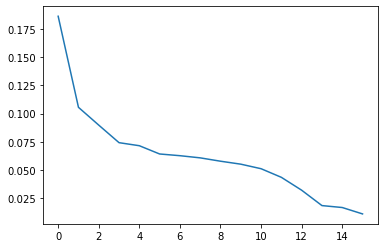

In [74]:
# wybranie odpowiedniej ilosci komponentow PCA

## najpierw max kolumn, a potem sprawdzic ile jest nam rzeczywiscie potrzebnych 
PCA_results = PCA(n_components = 16)

PCA_results.fit(X_train_scaled)
X_train_scaled_PCA = PCA_results.transform(X_train_scaled)
X_test_scaled_PCA = PCA_results.transform(X_test_scaled) 

plt.plot(PCA_results.explained_variance_ratio_)

In [75]:
np.cumsum(PCA_results.explained_variance_ratio_)

array([0.18650245, 0.29209765, 0.38188196, 0.45606811, 0.52755008,
       0.59169153, 0.65431283, 0.71500802, 0.77273208, 0.82782356,
       0.8788745 , 0.92227164, 0.95422597, 0.97252306, 0.9891024 ,
       1.        ])

Jak widzimy 10 zmiennych wyjasnia zmiennosc modelu w prawie 83%, ale skorzystajmy z 11, bo wariancja jeszcze sie calkiem mocna poprawia po dodaniu jednej zmiennej i mamy wynik 88%.

In [76]:
#ostateczna wersja PCA
PCA_results = PCA(n_components = 11)

PCA_results.fit(X_train_scaled)
X_train_scaled_PCA = PCA_results.transform(X_train_scaled)
X_test_scaled_PCA = PCA_results.transform(X_test_scaled) 

Sprawdzmy teraz wynik modelu na zmiennych po standaryzacji i PCA, wykorzystamy najlepszy wytrenowany dotad model ll3


In [77]:
# sprawdzmy jak sie sprawuje nasz model ze wskazanymi parametrami
model_ll4 =  RandomForestClassifier(max_depth= 14, max_features = 9,max_leaf_nodes= 22, n_estimators = 70,
                                   class_weight= {0: 0.1163265306122449, 1: 0.883673469387755}, random_state= 1).fit(X_train_scaled_PCA, Y_train)

Y_pred_ll4 =  model_ll4.predict(X_test_scaled_PCA)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_ll4.score(X_train_scaled_PCA, Y_train),4), "\n",
      "acc test: ", round(model_ll4.score(X_test_scaled_PCA, Y_test),4))



acc train:  0.9562 
 acc test:  0.9338


In [78]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_ll4 = confusion_matrix(Y_test, Y_pred_ll4)
raport_ll4 = classification_report(Y_test, Y_pred_ll4)
print(raport_ll4)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       935
           1       0.25      0.19      0.22        47

    accuracy                           0.93       982
   macro avg       0.60      0.58      0.59       982
weighted avg       0.93      0.93      0.93       982



Poprawila nam sie accuracy calkowita i dla klasy 0, jednak dla klasy 1 precyzja i czulosc wciaz sa niskie.

**9. Ze wzgledu na skalowanie i PCA model moze wymagac innych parametrow w takim razie poszukajmy bardziej optymalnego zestawu parametrow**

In [79]:
# stwórzmy najpierw zestaw parametrów do testów
params_ll5 = {"max_depth": list(range(2,36,3)),
              "max_features" : list(range(3,12,2)),
              "max_leaf_nodes" : list(range(2,58,5)),
              "n_estimators" : list(range(50,200,10))}

r=  0   # policzymy ile jest mozliwych kombinacji parametrow
for j in params_ll2.values():
    s=len(j)
    r += s

In [80]:
# wylosujmy najlepsze kombinacje parametrów dla tego modelu.
clf5 = RandomForestClassifier(random_state=1) 

random  = RandomizedSearchCV(clf5, param_distributions = params_ll5, cv = 5, n_iter = round(r/3,0), scoring = make_scorer(f1_score, average = "macro"))

random.fit(X_train_scaled_PCA, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=15.0,
                   param_distributions={'max_depth': [2, 5, 8, 11, 14, 17, 20,
                                                      23, 26, 29, 32, 35],
                                        'max_features': [3, 5, 7, 9, 11],
                                        'max_leaf_nodes': [2, 7, 12, 17, 22, 27,
                                                           32, 37, 42, 47, 52,
                                                           57],
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                                         180, 190]},
                   scoring=make_scorer(f1_score, average=macro))

In [81]:
# otrzymamy liste 10 najlepszych zestawow parametrow z posrod wylosowanych
ranks_ll5 = random.cv_results_['rank_test_score']
ranks_ll5.sort()
n = 10

for i in range(n):
    print(random.cv_results_['params'][ranks_ll5[i]])


{'n_estimators': 100, 'max_leaf_nodes': 47, 'max_features': 7, 'max_depth': 2}
{'n_estimators': 60, 'max_leaf_nodes': 52, 'max_features': 3, 'max_depth': 26}
{'n_estimators': 160, 'max_leaf_nodes': 2, 'max_features': 11, 'max_depth': 17}
{'n_estimators': 80, 'max_leaf_nodes': 42, 'max_features': 7, 'max_depth': 14}
{'n_estimators': 150, 'max_leaf_nodes': 22, 'max_features': 5, 'max_depth': 8}
{'n_estimators': 140, 'max_leaf_nodes': 32, 'max_features': 11, 'max_depth': 5}
{'n_estimators': 170, 'max_leaf_nodes': 32, 'max_features': 5, 'max_depth': 14}
{'n_estimators': 160, 'max_leaf_nodes': 27, 'max_features': 9, 'max_depth': 20}
{'n_estimators': 160, 'max_leaf_nodes': 27, 'max_features': 9, 'max_depth': 20}
{'n_estimators': 100, 'max_leaf_nodes': 22, 'max_features': 7, 'max_depth': 2}


Niestety losowane parametry nie ukazały nam zbyt wiele prawidłowości, dlatego model zostanie wytrenowany na wszystkich parametrach. 

In [229]:
# dodajmy do modelu wylosowane najlepsze parametry
new_params_ll5 =  {"max_depth": list(range(2,36,3)),
              "max_features" : list(range(3,12,2)),
              "max_leaf_nodes" : list(range(12,58,5)),
              "n_estimators" : list(range(70,180,20))}

In [230]:
# wybierzmy teraz najlepszy zestaw parametrow z okrojonej listy parametrow
grid_search_ll5 = GridSearchCV(clf5, param_grid = new_params_ll5, cv = 5, verbose = 1, scoring = make_scorer(f1_score, average = "macro")).fit(X,Y)


Fitting 5 folds for each of 5040 candidates, totalling 25200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25200 out of 25200 | elapsed: 309.8min finished


In [231]:
# mamy proponowany najlepszy zestaw parametrow
grid_search_ll5.best_params_

{'max_depth': 29, 'max_features': 11, 'max_leaf_nodes': 52, 'n_estimators': 70}

In [232]:
# sprawdzmy jak sie sprawuje nasz model ze wskazanymi parametrami
model_ll5 =  RandomForestClassifier(max_depth= 29, max_features = 11,max_leaf_nodes= 52, n_estimators = 70, random_state=1).fit(X_train_scaled_PCA, Y_train)

Y_pred_ll5 =  model_ll5.predict(X_test_scaled_PCA)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_ll5.score(X_train_scaled_PCA, Y_train),4), "\n",
      "acc test: ", round(model_ll5.score(X_test_scaled_PCA, Y_test),4))

acc train:  0.9621 
 acc test:  0.9521


In [233]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_ll5 = confusion_matrix(Y_test, Y_pred_ll5)
raport_ll5 = classification_report(Y_test, Y_pred_ll5)
print(raport_ll5)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       973
           1       0.00      0.00      0.00        49

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.91      0.95      0.93      1022



C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Niestety ponownie wynik dobry tylko dla 1 klasy, pozostalo nam jeszcze sprawdzic czy zmiana wag cos pomoze.

In [235]:
# wybierzmy teraz najlepszy zestaw wag dla modelu
grid_search_ll6 = GridSearchCV(model_ll5, param_grid = param_grid_weight, cv = 5, verbose = 1, scoring = make_scorer(f1_score, average = "macro")).fit(X,Y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished


In [236]:
#w ten sposob uzyskalismy najlepszy model przy ponizszych wagach
grid_search_ll6.best_params_

{'class_weight': {0: 0.1163265306122449, 1: 0.883673469387755}}

In [237]:
# sprawdzmy jak sie sprawuje nasz model ze wskazanymi parametrami
model_ll6 =  RandomForestClassifier(max_depth= 14, max_features = 9,max_leaf_nodes= 22, n_estimators = 70,
                                   class_weight= {0: 0.1163265306122449, 1: 0.883673469387755}, random_state= 1).fit(X_train_scaled_PCA, Y_train)

Y_pred_ll6 =  model_ll6.predict(X_test_scaled_PCA)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_ll6.score(X_train_scaled_PCA, Y_train),4), "\n",
      "acc test: ", round(model_ll6.score(X_test_scaled_PCA, Y_test),4))

acc train:  0.9408 
 acc test:  0.9237


In [238]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_ll6 = confusion_matrix(Y_test, Y_pred_ll6)
raport_ll6 = classification_report(Y_test, Y_pred_ll6)
print(raport_ll6)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       973
           1       0.19      0.18      0.19        49

    accuracy                           0.92      1022
   macro avg       0.58      0.57      0.57      1022
weighted avg       0.92      0.92      0.92      1022



Sprawdzmy jeszcze przypisanie do klasy decyzyjnej przy 0.4 i 0.6

In [241]:
# sprobujmy przypisac ze decyzja o przypisaniu jest podejmowana gdy prawdopodobienstwo wynosi >0,4, >0.6, >0.8
decyzje2 = pd.DataFrame( model_ll6.predict_proba(X_test_scaled_PCA)[::,1], columns= ["a"])

lista_04_2 = []
lista_06_2 = []

for i in decyzje2["a"]:
    if i >0.6:
        lista_06_2.append(1)
    else:
        lista_06_2.append(0)
    if i >0.4:
        lista_04_2.append(1)
    else:
        lista_04_2.append(0)

In [244]:
# przeanalizujmy jak w tych wypadkach wyglada nasza macierz pomylek
matrix_ll6_06 = confusion_matrix(Y_test, lista_06_2)
raport_ll6_06 = classification_report(Y_test, lista_06_2)
print(raport_ll6_06)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       973
           1       0.22      0.08      0.12        49

    accuracy                           0.94      1022
   macro avg       0.59      0.53      0.54      1022
weighted avg       0.92      0.94      0.93      1022



In [245]:
# przeanalizujmy jak w tych wypadkach wyglada nasza macierz pomylek
matrix_ll6_04 = confusion_matrix(Y_test, lista_04_2)
raport_ll6_04 = classification_report(Y_test, lista_04_2)
print(raport_ll6_04)

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       973
           1       0.14      0.31      0.19        49

    accuracy                           0.88      1022
   macro avg       0.55      0.61      0.56      1022
weighted avg       0.92      0.88      0.90      1022



**10.Jako kolejna metode walki z niezbalansowanym zbiorem wypróbujmy duplikacje sampli w klasie 1**

In [82]:
#powiekszmy sobie nasz zbior dla klasy 1. o 2000 losowych obserwacji
losowe_indeksy = np.random.randint(1,249, 2000)
zbior1 = df_dummy[df_dummy.stroke == 1]

duplikaty = pd.DataFrame()
for i in losowe_indeksy:
    zbior1 = zbior1.append(zbior1.iloc[i:i+1,])
    
zbior1.reset_index()
    
df_dummy_duplicated = df_dummy[df_dummy.stroke == 0].append(zbior1)

In [83]:
# zdefiniujmy zbiór X i Y bez podzialu na testowy do cross validacji
X_duplicated = df_dummy_duplicated.iloc[:,0:3].join(df_dummy.iloc[:,4:])
Y_duplicated  = df_dummy_duplicated ["stroke"]

In [84]:
# podzielmy też na zbiór treningowy i testowy
X_train_duplicated, X_test_duplicated, Y_train_duplicated,Y_test_duplicated = train_test_split(X_duplicated,Y_duplicated, test_size = 0.2, random_state=1)

Spróbujmy znaleźć najlepsze parametry dla nowego modelu, wykorzystamy model random forrest.

In [298]:
# stwórzmy najpierw zestaw parametrów do testów
params_ll7 =  {"max_depth": list(range(2,36,3)),
              "max_features" : list(range(3,12,2)),
              "max_leaf_nodes" : list(range(2,58,5)),
              "n_estimators" : list(range(70,200,20))}


r=  0   # policzymy ile jest mozliwych kombinacji parametrow
for j in params_ll2.values():
    s=len(j)
    r += s

In [300]:
# wylosujmy najlepsze kombinacje parametrów dla tego modelu.
clf7 = RandomForestClassifier(random_state=1) 

random  = RandomizedSearchCV(clf7, param_distributions = params_ll7, cv = 5, n_iter = round(r/3,0), scoring = make_scorer(f1_score, average = "macro"))

random.fit(X_train_duplicated, Y_train_duplicated)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=15.0,
                   param_distributions={'max_depth': [2, 5, 8, 11, 14, 17, 20,
                                                      23, 26, 29, 32, 35],
                                        'max_features': [3, 5, 7, 9, 11],
                                        'max_leaf_nodes': [2, 7, 12, 17, 22, 27,
                                                           32, 37, 42, 47, 52,
                                                           57],
                                        'n_estimators': [70, 90, 110, 130, 150,
                                                         170, 190]},
                   scoring=make_scorer(f1_score, average=macro))

In [301]:
# otrzymamy liste 10 najlepszych zestawow parametrow z posrod wylosowanych
ranks_ll7 = random.cv_results_['rank_test_score']
ranks_ll7.sort()
n = 10

for i in range(n):
    print(random.cv_results_['params'][ranks_ll7[i]])

{'n_estimators': 110, 'max_leaf_nodes': 27, 'max_features': 3, 'max_depth': 17}
{'n_estimators': 150, 'max_leaf_nodes': 22, 'max_features': 5, 'max_depth': 2}
{'n_estimators': 170, 'max_leaf_nodes': 2, 'max_features': 9, 'max_depth': 14}
{'n_estimators': 70, 'max_leaf_nodes': 37, 'max_features': 3, 'max_depth': 2}
{'n_estimators': 150, 'max_leaf_nodes': 17, 'max_features': 5, 'max_depth': 23}
{'n_estimators': 130, 'max_leaf_nodes': 17, 'max_features': 9, 'max_depth': 20}
{'n_estimators': 70, 'max_leaf_nodes': 27, 'max_features': 9, 'max_depth': 29}
{'n_estimators': 170, 'max_leaf_nodes': 32, 'max_features': 11, 'max_depth': 35}
{'n_estimators': 190, 'max_leaf_nodes': 42, 'max_features': 5, 'max_depth': 2}
{'n_estimators': 150, 'max_leaf_nodes': 2, 'max_features': 7, 'max_depth': 20}


In [85]:
# sprawdzmy od razu czy jest sens dalej szukac parametrow, czyli jak sie sprawuje nasz model ze wskazanymi parametrami
model_ll7 =  RandomForestClassifier(max_depth= 20, max_features = 11,max_leaf_nodes= 27, n_estimators = 110,random_state=1).fit(X_train_duplicated, Y_train_duplicated)

Y_pred_ll7 =  model_ll7.predict(X_test_duplicated)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_ll7.score(X_train_duplicated, Y_train_duplicated),4), "\n",
      "acc test: ", round(model_ll7.score(X_test_duplicated, Y_test_duplicated),4))

acc train:  0.6971 
 acc test:  0.6881


Wynik Acc bardzo niski, jak to wyglada dalej:


In [86]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_ll7 = confusion_matrix(Y_test_duplicated, Y_pred_ll7)
raport_ll7 = classification_report(Y_test_duplicated, Y_pred_ll7)
print(raport_ll7)

              precision    recall  f1-score   support

           0       0.69      0.98      0.81       946
           1       0.55      0.06      0.11       436

    accuracy                           0.69      1382
   macro avg       0.62      0.52      0.46      1382
weighted avg       0.65      0.69      0.59      1382



Ta metoda w tym przypadku nie zdała egzaminu.


**11.Ostatnią metodą bedzie regresja logistyczna na przeskalowanych danych + PCA**

In [87]:
model_lr3 = LogisticRegression(random_state=1)
model_lr3.fit(X_train_scaled_PCA, Y_train)
Y_pred_lr3 = model_lr3.predict(X_test_scaled_PCA)

In [88]:
#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_lr3.score(X_train_scaled_PCA, Y_train),4), "\n",
      "acc test: ", round(model_lr3.score(X_test_scaled_PCA, Y_test),4))

acc train:  0.9587 
 acc test:  0.9521


In [89]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_lr3 = confusion_matrix(Y_test, Y_pred_lr3)
raport_lr3 = classification_report(Y_test, Y_pred_lr3)
print(raport_lr3)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       935
           1       0.00      0.00      0.00        47

    accuracy                           0.95       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.91      0.95      0.93       982



C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Niestety nic z tego, nie widzę potrzeby dalszych prób.

**12. Podsumowanie**  
Wykorzystujac przedstawione tutaj metody, najlepszy wyniki, przedstawiony za pomoca F1 score dla obu klas, uzyskaliśmy stosujac model model_ll3 o parametrach jak ponizej.

In [247]:
model_ll3

RandomForestClassifier(class_weight={0: 0.1163265306122449,
                                     1: 0.883673469387755},
                       max_depth=14, max_features=9, max_leaf_nodes=22,
                       n_estimators=70)

In [249]:
print("nasz wynik to: \n", raport_ll3)

nasz wynik to: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       973
           1       0.21      0.45      0.28        49

    accuracy                           0.89      1022
   macro avg       0.59      0.68      0.61      1022
weighted avg       0.93      0.89      0.91      1022



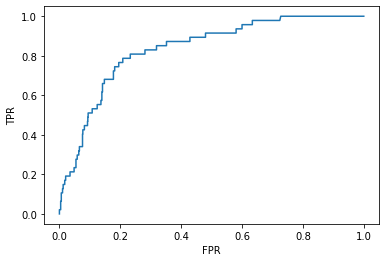

In [40]:
#wyliczmy AUC-ROC dla naszego najlepszego modelu
Y_pred_proba_ll3 = model_ll3.predict_proba(X_test)[::,1]
FPR, TPR,_ = roc_curve(Y_test,Y_pred_proba_ll3)
AUC = roc_auc_score(Y_test,Y_pred_proba_ll3)

plt.plot(FPR, TPR, label = "wynik " + str(AUC))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Szukamy pkt, w którym mamy najwyzsze TPR i wzglednie niskie FPR,
możemy uznać, że właściwym progiem klasyfikacji dla tego modelu bedzie nawet 0.2

In [ ]:
#Sprawdzmy jak rzeczywiscie prezentuje sie modele przy klasyfikacji od progu 0.8

In [64]:
#przypiszmy, więc decyzje na podstawie prawdopodobienstwo 0.2 i wyzej do klasy 1

decyzje = pd.DataFrame( model_ll3.predict_proba(X_test)[::,1], columns= ["a"])

lista_02 = []
for i in decyzje["a"]:
    if i >0.2:
        lista_02.append(1)
    else:
        lista_02.append(0)

In [63]:
matrix_ll3_02 = confusion_matrix(Y_test, lista_02)
raport_ll3_02 = classification_report(Y_test, lista_02)
print(raport_ll3_02)

              precision    recall  f1-score   support

           0       0.99      0.68      0.80       975
           1       0.11      0.85      0.20        47

    accuracy                           0.69      1022
   macro avg       0.55      0.76      0.50      1022
weighted avg       0.95      0.69      0.78      1022



**Nasz finalny model charakteryzuje się niską acc, bo 0.69, ale za to:**
- poprawnie rozpoznaje 99% klasy 0,
- jezeli juz przypisze kogos do klasy 1, to z 85% prawdopodobienstwem 


Niestety, przypisuje poprawnie tylko 11% objektów klasy 1.

**II Zaawansowane modele**

**1.wykorzystajmy w naszej analizie model XGBoost**

In [90]:
# prosty model xgb, nr1

model_xgb1= XGBClassifier(objective = 'binary:logistic',random_state=1).fit(X_train, Y_train, eval_metric = "logloss")

Y_pred_xgb1 =  model_xgb1.predict(X_test)

#ocena modelu na danych treningowych i testowych 
print("acc train: ",round(model_xgb1.score(X_train, Y_train),4), "\n",
      "acc test: ", round(model_xgb1.score(X_test, Y_test),4))



C:\Users\Dawid\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


acc train:  0.9982 
 acc test:  0.946


In [91]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_xgb1 = confusion_matrix(Y_test, Y_pred_xgb1)
raport_xgb1 = classification_report(Y_test, Y_pred_xgb1)
print(raport_xgb1)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       935
           1       0.25      0.06      0.10        47

    accuracy                           0.95       982
   macro avg       0.60      0.53      0.54       982
weighted avg       0.92      0.95      0.93       982



Widzimy, że prostym modelem XGB nie poprawiliśmy wyników dla 1 klasy.  
Spróbujmy znaleźć bardziej optymalny zestaw parametrów przy użyciu optymalizatowra hyperopt

In [169]:
#dane musza byc w odpowiednim formacie, dlatego dostosujmy df do formatu array
X_train_array = X_train.values
X_test_array = X_test.values

#dostosujmy wartosci Y, za pomoca LabelEncoder
le  = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)
Y_test_encoded = le.fit_transform(Y_test)

In [93]:
def run_xgb_hyperopt(X,Y,cv, num_eval):
    def objective(parametry): #zdefiniujmy funkcje celu
        model = XGBClassifier(**parametry, random_state = 10, objective = "binary:logistic",
                              n_jobs = 2,use_label_encoder=False, scale_pos_weight = 10)
                
        for a, b in cv.split(X, Y):
            eval_set = [(X[a],Y[a]),(X[b],Y[b])]
            model.fit(X[a],Y[a],eval_set = eval_set, eval_metric = 'logloss', early_stopping_rounds = 10, verbose = 0) 
            y_pred = model.predict(X[b])
            score =cohen_kappa_score(Y[b],y_pred)
           # print("kappa score: {:.4f}".format(score))
            return{'loss': -score, 'status':STATUS_OK}
        
    parametry ={
        'max_depth': scope.int(hp.quniform('max_depth',5,15,1)),
        'n_estimators' : hp.choice('n_estimators', np.arange(20, 150, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.001, 0.5, 0.005),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }  
    
    trials = Trials()
    
    best = fmin(fn=objective,
                space = parametry,
                algo = tpe.suggest,
                max_evals = num_eval,
                trials = trials)
    hyperparams = space_eval(parametry, best)
    
    print("Najlepsze parametry: ", hyperparams)
    return hyperparams

In [94]:
#zdefiniujmy jeszcze rodzaj walidacji, jako wykorzystamy
kF = StratifiedKFold(n_splits = 5, shuffle= True, random_state= 10)

In [95]:
# odaplenie hyeropt
best_XGB = run_xgb_hyperopt(X_train_array, Y_train_encoded, cv=kF, num_eval=20)


100%|██████| 20/20 [00:10<00:00,  1.86trial/s, best loss: -0.14540595771437548]
Najlepsze parametry:  {'colsample_bytree': 0.6000000000000001, 'gamma': 0.75, 'learning_rate': 0.405, 'max_depth': 6, 'min_child_weight': 10.0, 'n_estimators': 22, 'subsample': 0.7201127678892102}


In [96]:
# uruchomie teraz nasz najlepszy model
model_xgb2 = XGBClassifier(**best_XGB, objective= "binary:logistic",use_label_encoder=False,random_state=1).fit(X_train,Y_train_encoded, eval_metric = 'logloss')
Y_pred_xgb2 = model_xgb2.predict(X_test)

In [97]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_xgb2 = confusion_matrix(Y_test_encoded, Y_pred_xgb2)
raport_xgb2 = classification_report(Y_test_encoded, Y_pred_xgb2)
print(raport_xgb2)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       935
           1       0.50      0.02      0.04        47

    accuracy                           0.95       982
   macro avg       0.73      0.51      0.51       982
weighted avg       0.93      0.95      0.93       982



Jak widzimy bardziej zaawansowana metoda, jako jest XGBoost wraz z optymalizatorem parametrów przy użyciu hyperopta nie poprawiła znacznie naszego najlepszego wyniku osiagnietego przez model RandomForrest.
Pokazuje nam z 98% dokladnościa przypadki braku ataku serca, ale bardzo słabo przewiduje faktyczne ataki serca

**III Sieć neuronowa**

In [299]:
import tensorflow as tf
from keras import layers
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE


In [135]:
# transformujemy Y_test i Y_train

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_test = OneHotEncoder().fit_transform(Y_test.reshape(-1,1)).toarray()
Y_train = OneHotEncoder().fit_transform(Y_train.reshape(-1,1)).toarray()

# zmienmy jeszcze format
Y_test = Y_test.astype(np.float32)
Y_train = Y_train.astype(np.float32)

In [335]:
#definicja modelu
def model_nn(X,Y, units, drop, classNum, epoch, lr = 0.01, bn = False):
    '''
    X - dane treningowe w postaci array bez labeli,
    Y - labeli dla danych treningowych
    units - lista unitow dla poszczegolnych warstw
    drop - poziom dropoutu dla poszczegolnej wartswy
    classNum = ilosc klas 
    epoch - liczba epok podczas trenowania 
    lr - learning rate
    bn - czy zastosowac batch normalization 
    '''
    model = tf.keras.models.Sequential()
    model.add(layers.InputLayer(input_shape = X.shape[1]))
    for i, j in enumerate(units):
        model.add(layers.Dense(j, activation='relu', name="ukryta_" + str(i)))
        model.add(layers.Dropout(drop))
        if bn == True:
            model.add(layers.BatchNormalization())
                  
    model.add(layers.Dense(classNum, name="WYJSCIE"))
    model.add(layers.Softmax())
    
    model.summary()
    
    optymalizator = tf.optimizers.Adam(lr)
    
    model.compile(optimizer=optymalizator,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['AUC'])
    
    results = model.fit(X,Y, validation_split= 0.2, epochs=epoch, verbose=1,
              callbacks=[callbacks.EarlyStopping(monitor= 'val_auc', min_delta=0.1, 
                                                    patience=5)])
    return model

In [188]:
model_nn1 = model_nn(X_train_array, Y_train,[512,256,64],0.3,2,30)
Y_pred_nn1 = model_nn1.predict(X_test_array).argmax(axis = 1)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ukryta_0 (Dense)             (None, 512)               8704      
_________________________________________________________________
dropout_42 (Dropout)         (None, 512)               0         
_________________________________________________________________
ukryta_1 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)               0         
_________________________________________________________________
ukryta_2 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
WYJSCIE (Dense)              (None, 2)               

In [172]:
# szybka ewaluacja
eval_res = model_nn1.evaluate(X_test_array, Y_test)
eval_names = model_nn1.metrics_names
print(f"{eval_names[0]}: {eval_res[0]}")
print(f"{eval_names[1]}: {eval_res[1]}")

31/31 [==============================] - 0s 3ms/step - loss: 0.7341 - auc: 0.9521
loss: 0.7340565323829651
auc: 0.9521384239196777


In [198]:
#obejrzyjmy jeszcze macierz pomyłek 
matrix_nn1 = confusion_matrix(Y_test.argmax(axis = 1), Y_pred_nn1)
raport_nn1 = classification_report(Y_test.argmax(axis = 1), Y_pred_nn1)
print(raport_nn1)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       935
           1       0.00      0.00      0.00        47

    accuracy                           0.95       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.91      0.95      0.93       982



C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model nie rozpoznaje w ogóle klasy 2, spróbujmy innych konfiguracji.

In [201]:
model_nn2 = model_nn(X_train_array, Y_train,[256,128],0.5,2,30,0.1)
Y_pred_nn2 = model_nn2.predict(X_test_array).argmax(axis = 1)

# szybka ewaluacja
eval_res = model_nn2.evaluate(X_test_array, Y_test)
eval_names = model_nn2.metrics_names
print(f"{eval_names[0]}: {eval_res[0]}")
print(f"{eval_names[1]}: {eval_res[1]}")

#obejrzyjmy jeszcze macierz pomyłek 
matrix_nn2 = confusion_matrix(Y_test.argmax(axis = 1), Y_pred_nn2)
raport_nn2 = classification_report(Y_test.argmax(axis = 1), Y_pred_nn2)
print(raport_nn2)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ukryta_0 (Dense)             (None, 256)               4352      
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
ukryta_1 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
WYJSCIE (Dense)              (None, 2)                 258       
_________________________________________________________________
softmax_17 (Softmax)         (None, 2)                 0         
Total params: 37,506
Trainable params: 37,506
Non-trainable params: 0
_________________________________________________

C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [313]:
#Sprobujmy wykorzystac inne metode replikacje danych, dla poradzenia sobie z problemem niezbalansowania.

smote = SMOTE(sampling_strategy = 'minority')
x_sm, y_sm = smote.fit_resample(X,Y)


# podzielmy jeszcze raz zbior na zbior treningowy i testowy
X_train1, X_test1, Y_train1,Y_test1 = train_test_split(x_sm,y_sm, test_size = 0.2)

In [314]:
# Przetworzmy dane do formatu wejsciowego do modelu

X_train_array_d = X_train1.values
X_test_array_d = X_test1.values


# transformujemy Y_test_duplicated i Y_test_duplicated

Y_train_d = np.array(Y_train1)
Y_test_d = np.array(Y_test1)

Y_test_d = OneHotEncoder().fit_transform(Y_test_d.reshape(-1,1)).toarray()
# zmienmy jeszcze format
Y_test_d = Y_test_d.astype(np.float32)

# transformujemy y_train
Y_train_d = OneHotEncoder().fit_transform(Y_train_d.reshape(-1,1)).toarray()
# zmienmy jeszcze format
Y_train_d = Y_train_d.astype(np.float32)


In [316]:
model_nn3 = model_nn(X_train_array_d, Y_train_d,[256,128],0.5,2,30,0.1, True)
Y_pred_nn3 = model_nn3.predict(X_test_array_d).argmax(axis = 1)

# szybka ewaluacja
eval_res = model_nn3.evaluate(X_test_array_d, Y_test_d)
eval_names = model_nn3.metrics_names
print(f"{eval_names[0]}: {eval_res[0]}")
print(f"{eval_names[1]}: {eval_res[1]}")

#obejrzyjmy jeszcze macierz pomyłek 
matrix_nn3 = confusion_matrix(Y_test_d.argmax(axis = 1), Y_pred_nn3)
raport_nn3 = classification_report(Y_test_d.argmax(axis = 1), Y_pred_nn3)
print(raport_nn3)

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ukryta_0 (Dense)             (None, 256)               4352      
_________________________________________________________________
dropout_236 (Dropout)        (None, 256)               0         
_________________________________________________________________
batch_normalization_131 (Bat (None, 256)               1024      
_________________________________________________________________
ukryta_1 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_237 (Dropout)        (None, 128)               0         
_________________________________________________________________
batch_normalization_132 (Bat (None, 128)               512       
_________________________________________________________________
WYJSCIE (Dense)              (None, 2)              

Model po replikacji danych osiagnal znaczna poprawe, sprobujmy jeszcze kilku eksperymentów.

In [317]:
model_nn4 = model_nn(X_train_array_d, Y_train_d,[512],0.5,2,30,0.001, True)
Y_pred_nn4 = model_nn4.predict(X_test_array_d).argmax(axis = 1)

# szybka ewaluacja
eval_res = model_nn4.evaluate(X_test_array_d, Y_test_d)
eval_names = model_nn4.metrics_names
print(f"{eval_names[0]}: {eval_res[0]}")
print(f"{eval_names[1]}: {eval_res[1]}")

#obejrzyjmy jeszcze macierz pomyłek 
matrix_nn4 = confusion_matrix(Y_test_d.argmax(axis = 1), Y_pred_nn4)
raport_nn4 = classification_report(Y_test_d.argmax(axis = 1), Y_pred_nn4)
print(raport_nn4)

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ukryta_0 (Dense)             (None, 512)               8704      
_________________________________________________________________
dropout_238 (Dropout)        (None, 512)               0         
_________________________________________________________________
batch_normalization_133 (Bat (None, 512)               2048      
_________________________________________________________________
WYJSCIE (Dense)              (None, 2)                 1026      
_________________________________________________________________
softmax_111 (Softmax)        (None, 2)                 0         
Total params: 11,778
Trainable params: 10,754
Non-trainable params: 1,024
_________________________________________________________________
Epoch 1/30
188/188 [==============================] - 3s 6ms/step - loss: 0.5793 - auc: 0.8039 - val_loss: 0.4

In [321]:
model_nn5 = model_nn(X_train_array_d, Y_train_d,[512,128],0.2,2,30,0.0001, True)
Y_pred_nn5 = model_nn5.predict(X_test_array_d).argmax(axis = 1)

# szybka ewaluacja
eval_res = model_nn5.evaluate(X_test_array_d, Y_test_d)
eval_names = model_nn5.metrics_names
print(f"{eval_names[0]}: {eval_res[0]}")
print(f"{eval_names[1]}: {eval_res[1]}")

#obejrzyjmy jeszcze macierz pomyłek 
matrix_nn5 = confusion_matrix(Y_test_d.argmax(axis = 1), Y_pred_nn5)
raport_nn5 = classification_report(Y_test_d.argmax(axis = 1), Y_pred_nn5)
print(raport_nn5)

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ukryta_0 (Dense)             (None, 512)               8704      
_________________________________________________________________
dropout_243 (Dropout)        (None, 512)               0         
_________________________________________________________________
batch_normalization_138 (Bat (None, 512)               2048      
_________________________________________________________________
ukryta_1 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_244 (Dropout)        (None, 128)               0         
_________________________________________________________________
batch_normalization_139 (Bat (None, 128)               512       
_________________________________________________________________
WYJSCIE (Dense)              (None, 2)              

In [331]:
model_nn6 = model_nn(X_train_array_d, Y_train_d,[512,256],0.1,2,30,0.0001, True)
Y_pred_nn6 = model_nn6.predict(X_test_array_d).argmax(axis = 1)

# szybka ewaluacja
eval_res = model_nn6.evaluate(X_test_array_d, Y_test_d)
eval_names = model_nn6.metrics_names
print(f"{eval_names[0]}: {eval_res[0]}")
print(f"{eval_names[1]}: {eval_res[1]}")

#obejrzyjmy jeszcze macierz pomyłek 
matrix_nn6 = confusion_matrix(Y_test_d.argmax(axis = 1), Y_pred_nn6)
raport_nn6 = classification_report(Y_test_d.argmax(axis = 1), Y_pred_nn6)
print(raport_nn6)

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ukryta_0 (Dense)             (None, 512)               8704      
_________________________________________________________________
dropout_267 (Dropout)        (None, 512)               0         
_________________________________________________________________
batch_normalization_162 (Bat (None, 512)               2048      
_________________________________________________________________
ukryta_1 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_268 (Dropout)        (None, 256)               0         
_________________________________________________________________
batch_normalization_163 (Bat (None, 256)               1024      
_________________________________________________________________
WYJSCIE (Dense)              (None, 2)              

In [332]:
model_nn6 = model_nn(X_train_array_d, Y_train_d,[1024,256],0.1,2,30,0.0001, True)
Y_pred_nn6 = model_nn6.predict(X_test_array_d).argmax(axis = 1)

# szybka ewaluacja
eval_res = model_nn6.evaluate(X_test_array_d, Y_test_d)
eval_names = model_nn6.metrics_names
print(f"{eval_names[0]}: {eval_res[0]}")
print(f"{eval_names[1]}: {eval_res[1]}")

#obejrzyjmy jeszcze macierz pomyłek 
matrix_nn6 = confusion_matrix(Y_test_d.argmax(axis = 1), Y_pred_nn6)
raport_nn6 = classification_report(Y_test_d.argmax(axis = 1), Y_pred_nn6)
print(raport_nn6)

Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ukryta_0 (Dense)             (None, 1024)              17408     
_________________________________________________________________
dropout_269 (Dropout)        (None, 1024)              0         
_________________________________________________________________
batch_normalization_164 (Bat (None, 1024)              4096      
_________________________________________________________________
ukryta_1 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_270 (Dropout)        (None, 256)               0         
_________________________________________________________________
batch_normalization_165 (Bat (None, 256)               1024      
_________________________________________________________________
WYJSCIE (Dense)              (None, 2)              

# Podsumowanie 

Nasz model po zastosowanie zaawansowanej metody replikacji danych mniejszej klasy, poprzez interpolacje i dostrojenia parametrow modelu w sieci neuronowej uzyskał całkiem dobre wyniki na poziomie 88% dokladnosci
